In [226]:
import retro
import numpy as np
import scipy.ndimage
import glob
import pandas as pd

%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/bpinsard/.virtualenvs/neuromod_data3.10/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f', 'annotations']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
retro.data.Integrations.add_custom_path("/scratch/tmp/mario_plot/mario.stimuli")

In [3]:
def replay_bk2(
    bk2_path, skip_first_step=True, scenario=None, inttype=retro.data.Integrations.CUSTOM_ONLY
):
    """Make an iterator that replays a bk2 file, returning frames, keypresses and annotations.

    Example
    -------
    ```
    all_frames = []
    all_keys = []
    for frame, keys, annotations, sound in replay_bk2(path):
        all_frames.append(frame)
        all_keys.append(keys)
    ```

    Parameters
    ----------
    bk2_path : str
        Path to the bk2 file to replay.
    skip_first_step : bool
        Whether to skip the first step before starting the replay. The intended use of
        gym retro is to do so (i.e. True) but if the recording was not initiated as intended
        per gym-retro, not skipping (i.e. False) might be required. Default is True.
    scenario : str
        Path to the scenario json file. If None, the scenario.json file in the game integration
        folder will be used. Default is None.
    inttype : gym-retro Integration
        Type of gym-retro integration to use. Default is `retro.data.Integrations.CUSTOM_ONLY`
        for custom integrations, for default integrations shipped with gym-retro, use
        `retro.data.Integrations.STABLE`.

    Yields
    -------
    frame : numpy.ndarray
        Current frame of the replay, of shape (H,W,3).
    keys : list of bool
        Current keypresses, list of booleans stating whicn key is pressed or not. The ordered name
        of the keys is in `emulator.buttons`.
    annotations : dict
        Dictonary containing the annotations of the game : reward, done condition and the values of
        the variables that are extracted from the emulator's memory.
    sound : dict
        Dictionnary containing the sound output from the game : audio and audio_rate.
    """
    movie = retro.Movie(bk2_path)
    emulator = retro.make(movie.get_game(), scenario=scenario, inttype=inttype, render_mode=None)
    emulator.initial_state = movie.get_state()
    emulator.reset()
    if skip_first_step:
        movie.step()
    while movie.step():
        keys = []
        for p in range(movie.players):
            for i in range(emulator.num_buttons):
                keys.append(movie.get_key(i, p))
        frame, rew, done, truncated, info = emulator.step(keys)
        sound = {"audio": emulator.em.get_audio(), "audio_rate": emulator.em.get_audio_rate()}
        annotations = {"reward": rew, "done": done, "info": info}
        yield frame, keys, annotations, sound

In [476]:
MAX_LEVEL_SIZE=10000
def generate_map(bk2_path, skip_first_step=False):
    max_scroll_r = 0
    design = None
    for frame, keys, annotations, sound in replay_bk2(bk2_path, skip_first_step=skip_first_step):
        if design is None:
            design = np.zeros((frame.shape[0], MAX_LEVEL_SIZE, frame.shape[2]))
            cols = np.ones(MAX_LEVEL_SIZE, dtype=bool)
        scroll_x_pos = annotations["info"]["xscrollHi"] * 256 + annotations["info"]["xscrollLo"]
        scroll_x_pos_r = scroll_x_pos+frame.shape[1]
    
        if scroll_x_pos == 0:
            if cols[0] and annotations["info"]["player_x_posLo"] > 0:
                design[:,:frame.shape[1]] = frame
                cols[:frame.shape[1]] = False
        else:
            design[:,:scroll_x_pos_r][:,cols[:scroll_x_pos_r]] = frame[:,cols[scroll_x_pos:scroll_x_pos_r]]
            cols[scroll_x_pos:scroll_x_pos_r] = False
        max_scroll_r = max(max_scroll_r, scroll_x_pos_r)
    design = design[:,:max_scroll_r]
    return design

In [458]:
events_paths = sorted(glob.glob("/scratch/tmp/cneuromod.mario.raw/sub-03/ses-*/func/*_events.tsv"))
events = [pd.read_csv(ep,delimiter="\t") for ep in events_paths]

In [463]:
reps = sorted(glob.glob("/scratch/tmp/cneuromod.mario.raw/sub-03/ses-*/gamelogs/*_task-mario_level-w8l2_rep-*.bk2"))
len(reps)

40

In [464]:
first_rep = [ any([evts.stim_file[0] in rep for evts in events]) for rep in reps]
np.where(first_rep)

(array([ 0,  8, 14, 32, 34]),)

In [469]:
reps_data = []
for rep,skip_first_step in zip(reps, first_rep):
    reps_data.append((rep, [annotations["info"] for frame, keys, annotations, sound in replay_bk2(rep,skip_first_step=skip_first_step)]))

    

In [470]:
reps_x_pos = [np.asarray([d["player_x_posLo"] + d["player_x_posHi"]*256 for d in rep_data[1]]) for rep_data in reps_data]
rep_xmax = np.argmax([max(x_pos) for x_pos in reps_x_pos])

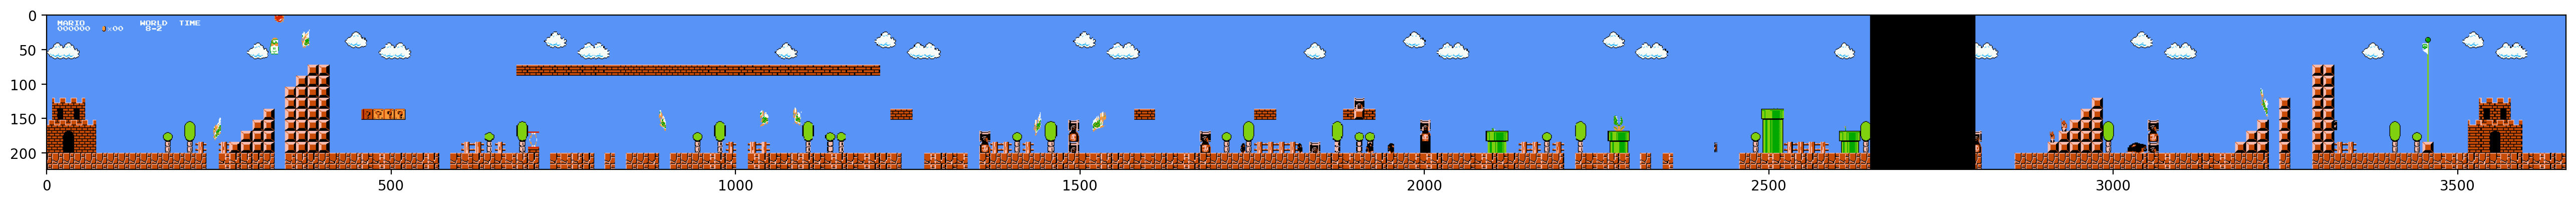

In [477]:
design = generate_map(reps[rep_xmax], skip_first_step=first_rep[rep_xmax])
f,ax = subplots(1,1,figsize=(64,2))
ax.imshow(design/255.)

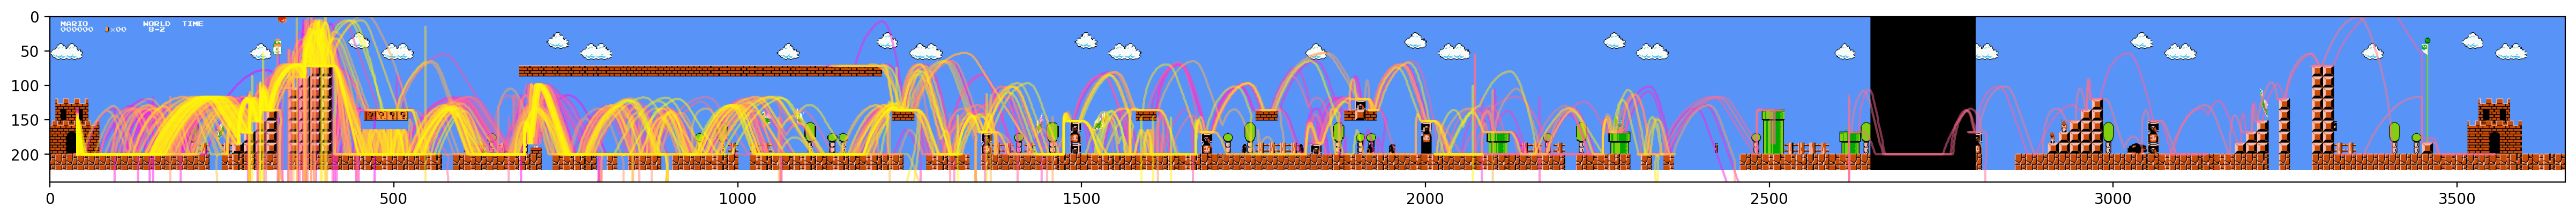

In [475]:
f,ax = subplots(1,1,figsize=(64,2))
ax.imshow(design/255.)

for rep_data, rep_x_pos in zip(reps_data, reps_x_pos):
    pstate = np.asarray([d["player_state"] for d in rep_data[1]])
    y_pos = np.asarray([float(d["player_y_pos"])+24-(1-d["player_y_screen_pos"])*256 for d in rep_data[1]])
    y_pos = np.ma.masked_where(pstate==0, y_pos)
    ax.plot(rep_x_pos, y_pos)
ax.set_ylim(240,0)

colormap = plt.cm.spring
colors = np.asarray([colormap(i) for i in np.linspace(0, 1,len(ax.lines))])
colors[:,-1]=.5
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])

24

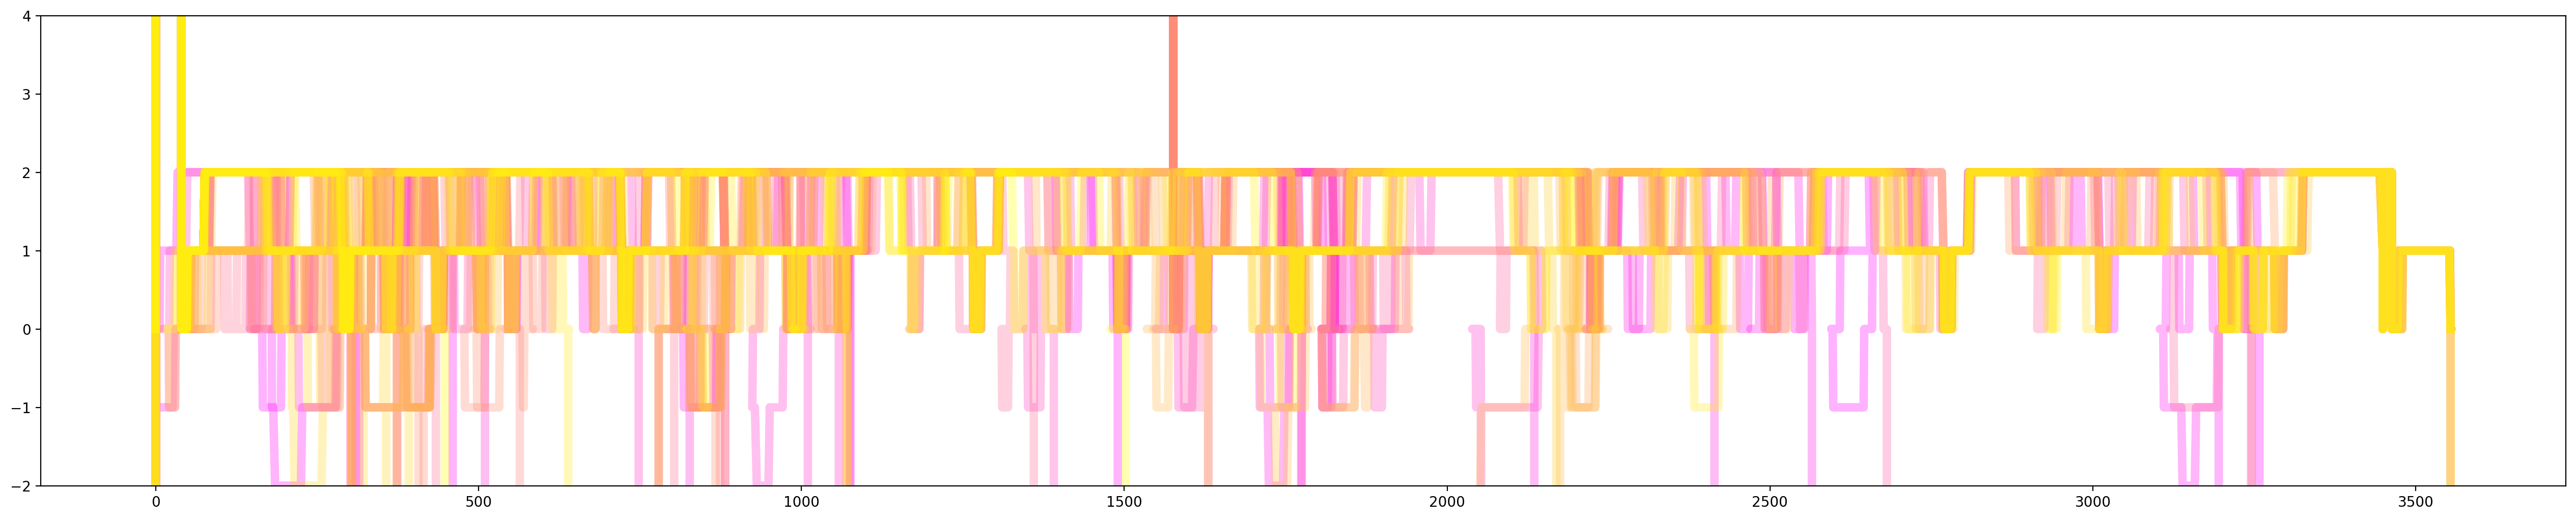

In [383]:
f,ax = subplots(1,1,figsize=(32,6))
for rep_data in reps_data:
    x_pos = np.asarray([d["player_x_posLo"] + d["player_x_posHi"]*256. for d in rep_data[1]],dtype=np.int32)
    #x_pos_mf = x_pos,4, mode='constant')
    ax.plot(x_pos, scipy.ndimage.gaussian_filter(np.ediff1d(x_pos, to_begin=[0]),2), linewidth=6)
ax.set_ylim([-2,4])
colors = np.asarray([colormap(i) for i in np.linspace(0, 1,len(ax.lines))])
colors[:,-1]=.3
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])

In [478]:
max_x = (np.max([np.max(rep_x_pos) for rep_x_pos in reps_x_pos ]))//6+1
MAX_NUM_LIVES=3 + 5 # 3 lives + 5 bonus
survival_indexed = np.empty((len(reps_data)*MAX_NUM_LIVES, max_x), dtype=np.float16)
survival_indexed.fill(np.nan)
index = np.zeros(max_x, dtype=np.int32)
for rep_idx, x_pos in enumerate(reps_x_pos):
    uniq_x_pos = np.unique(x_pos//6) #only counts position once per rep
    np.put(survival_indexed, np.ravel_multi_index(np.asanyarray([index[uniq_x_pos],uniq_x_pos]), survival_indexed.shape), rep_idx)
    index[uniq_x_pos]+=1
survival_indexed=survival_indexed[:max(index)+1]

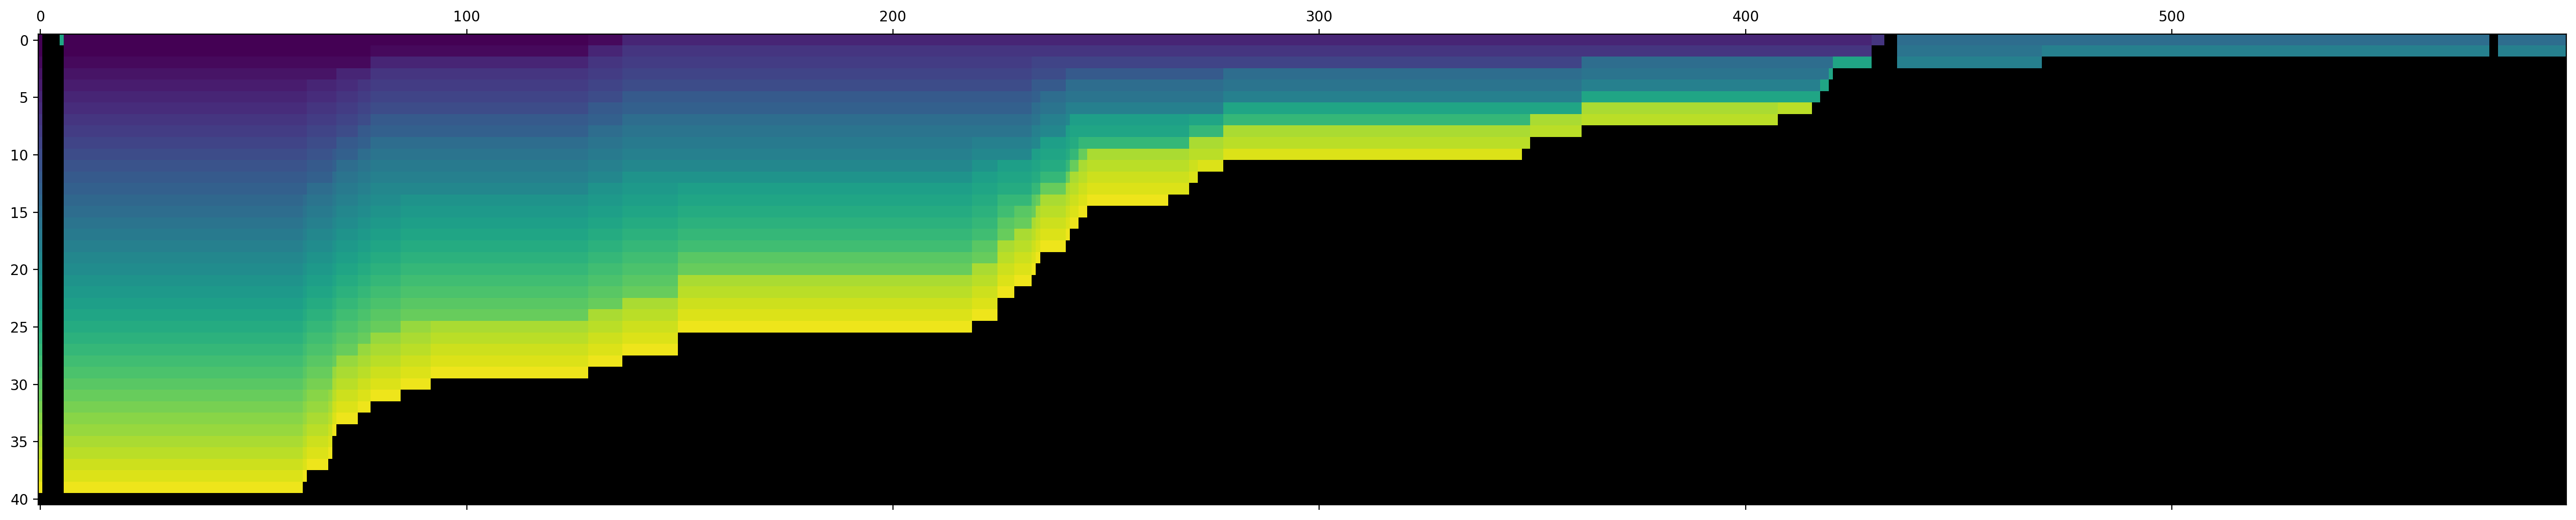

In [479]:
f,ax = subplots(1,1,figsize=(32,6))
cmap = matplotlib.cm.viridis
cmap.set_bad('black',1.)
survival_indexed_masked = np.ma.array (survival_indexed, mask=np.isnan(survival_indexed))
ax.matshow(survival_indexed_masked, aspect='auto', vmin=1, vmax=len(reps_data), cmap=cmap)

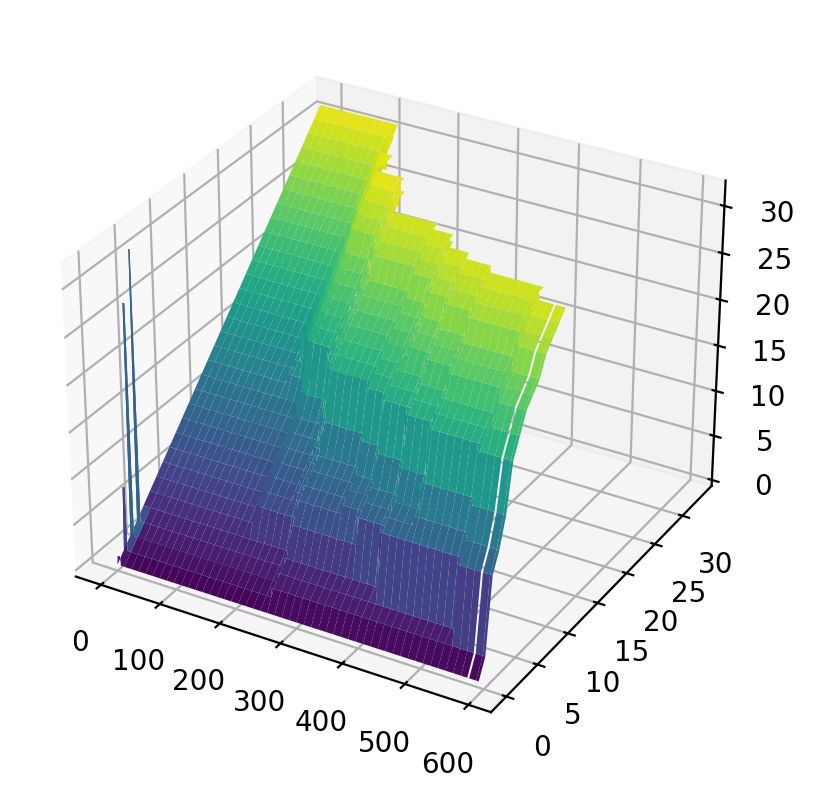

In [393]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xv, yv = np.meshgrid(np.arange(survival_indexed.shape[1]),np.arange(survival_indexed.shape[0]))
ax.plot_surface(xv,yv,survival_indexed_masked, cmap='viridis',vmin=0,vmax=len(reps_data))

In [427]:
np.unique([d["player_y_screen_pos"]+24 for d in rep_data[1]])

array([24, 25, 26, 27, 28])

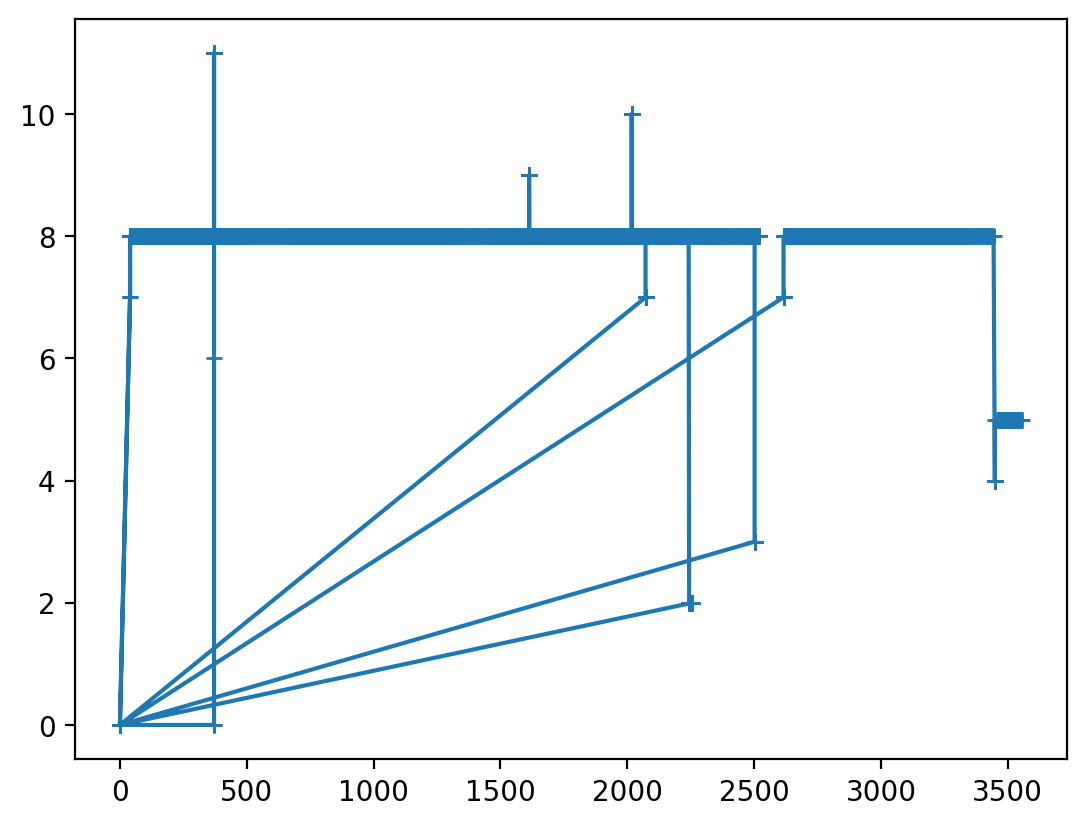

In [483]:
plot(reps_x_pos[rep_xmax],[d["player_state"] for d in reps_data[rep_xmax][1]],'+-')

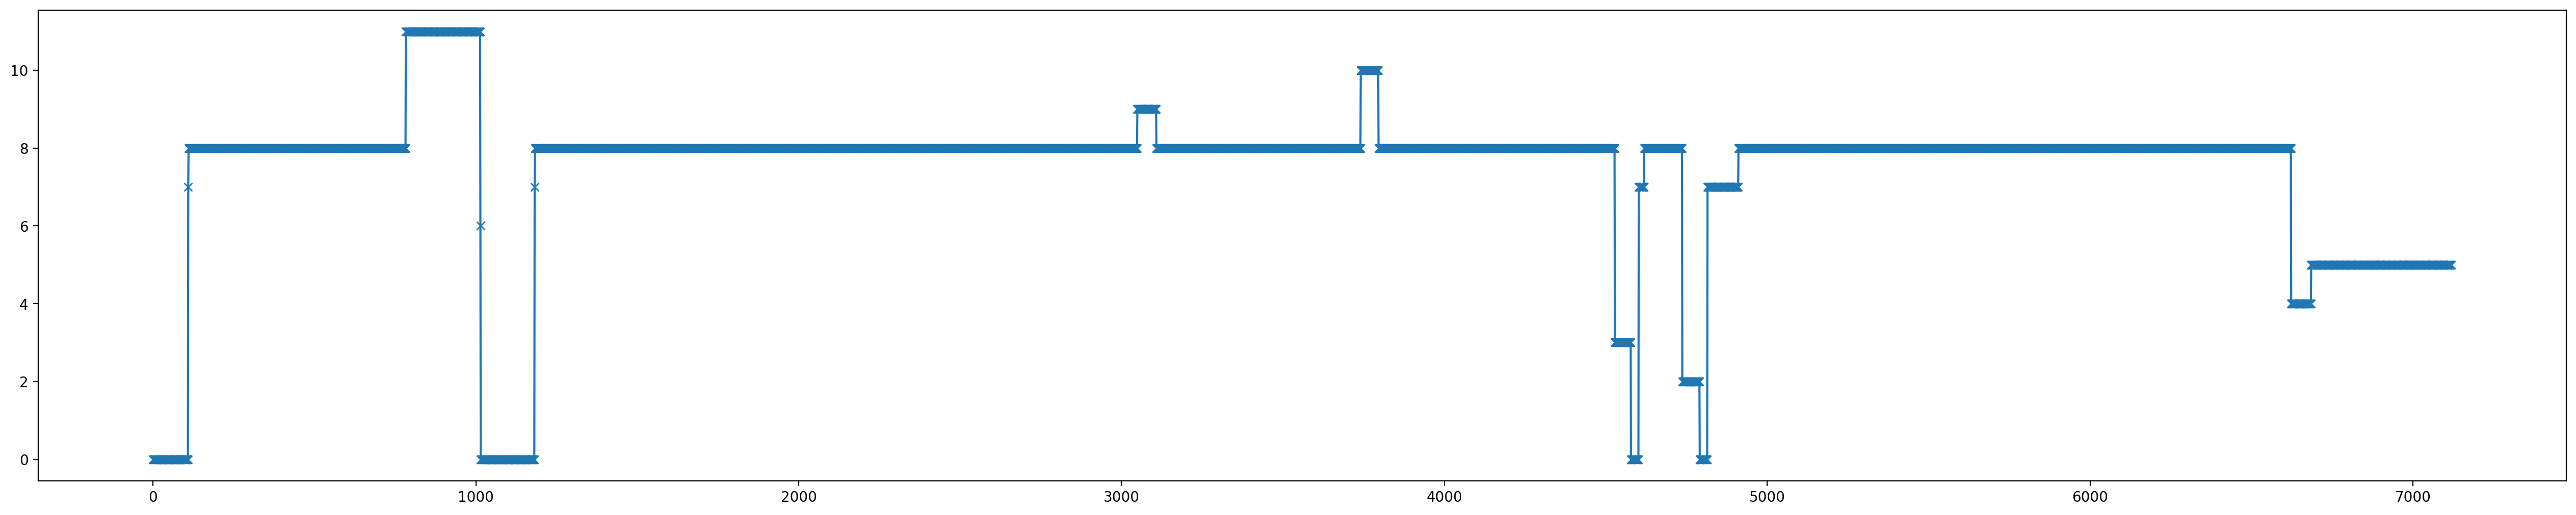

In [485]:
f,ax = subplots(1,1,figsize=(32,6))
ax.plot([d["player_state"] for d in reps_data[rep_xmax][1]],'-x')

In [428]:
rep_data = [annotations["info"] for frame, keys, annotations, sound in replay_bk2(rep)]

In [440]:
np.bincount([d['player_y_screen_pos'] for d in rep_data[1] ] )

array([ 462, 3121,  180,  183,  409])